# Classification using Keras

In this notebook, I'll work with the Malaria Cell Images dataset to classify cells as either **Parasitized** or **Uninfected**. I'll use **Convolutional Neural Networks** to make the classification.

## Import libraries

The first step is to import all the necessary packages including `sklearn`, `pandas`, `numpy`, `matplotlib` and `keras`. I'll work with **Tensorflow** as the backend. I'll also import `Image`, `cv2` and `os` to work with images.

In [1]:
import numpy as np
np.random.seed(1000)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

In [3]:
import os
import cv2
from PIL import Image

## Import dataset

I'll now import the dataset and take a look at the two types of image data available. I'll use the image size to be 64x64.

In [4]:
DATA_DIR = '../input/cell_images/cell_images/'
SIZE = 64
dataset = []
label = []

### Parasitized cell images

I iterate through all images in the **Parasitized** folder. I check if the file extension of the file being read is *png*.
I then resize the image to 64x64 and then save it to the `dataset` variable as numpy array. The label for this is set as `0`.

In [5]:
parasitized_images = os.listdir(DATA_DIR + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

### Uninfected cell images

I iterate through all images in the **Uninfected** folder. I check if the file extension of the file being read is *png*.
I then resize the image to 64x64 and then save it to the `dataset` variable as numpy array. The label for this is set as `0`.

In [6]:
uninfected_images = os.listdir(DATA_DIR + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

## Visualize data

Now, I'll take a look at 5 random images from both **Parasitized** and **Uninfected** pools.

### Parasitized images

I randomly select 10 values from the number of parasitized images and then display them in a row.

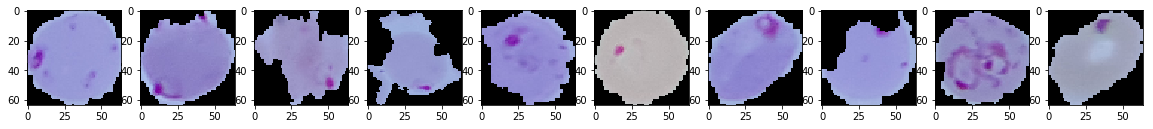

In [7]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images), size = 10)):
    plt.subplot(1, 10, index+1)
    plt.imshow(dataset[image_index])

### Uninfected images

I randomly select 10 values from the number of uninfected images and then display them in a row. I add the count of images of parasitized images to these index such that I am now showing images with label 1.

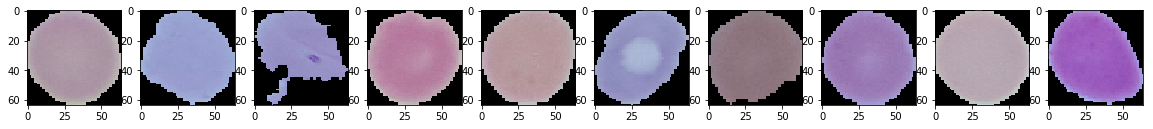

In [8]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images), size = 10)):
    plt.subplot(1, 10, index+1)
    plt.imshow(dataset[len(parasitized_images) + image_index])

## Applying CNN

I'll apply Convolutional Neural Networks with 2 Convolutional Layers followed by 2 Dense layers.

### Build the classifier

I create a Sequential model with all the layers. I used the metric as `accuracy`.

In [9]:
classifier = None
classifier = Sequential()
classifier.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=512))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'sigmoid', units=2))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(classifier.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxP

### Split the dataset

I split the dataset into training and testing dataset.
1. Training data: 80%
2. Testing data: 20%

In [10]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

In Keras, we can implement early stopping as a callback function. Callbacks are functions that can be applied at certain stages of the training process, such as at the end of each epoch. Specifically, in our solution, we included EarlyStopping(monitor='val_loss', patience=2) to define that we wanted to monitor the test (validation) loss at each epoch and after the test loss has not improved after two epochs, training is interrupted. However, since we set patience=2, we won’t get the best model, but the model two epochs after the best model. Therefore, optionally, we can include a second operation, ModelCheckpoint which saves the model to a file after every checkpoint (which can be useful in case a multi-day training session is interrupted for some reason. Helpful for us, if we set save_best_only=True then ModelCheckpoint will only save the best model.

In [11]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

### Training the model

As the training data is now ready, I will use it to train the classifier.

In [12]:
history = classifier.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 2, 
                         epochs = 50,
                         callbacks = callbacks,
                         validation_split = 0.1,
                         shuffle = False)

Instructions for updating:
Use tf.cast instead.
Train on 19841 samples, validate on 2205 samples
Epoch 1/50
 - 9s - loss: 0.4803 - acc: 0.7677 - val_loss: 1.4957 - val_acc: 0.6580
Epoch 2/50
 - 4s - loss: 0.2306 - acc: 0.9120 - val_loss: 0.2079 - val_acc: 0.9211
Epoch 3/50
 - 4s - loss: 0.1905 - acc: 0.9272 - val_loss: 0.2521 - val_acc: 0.9070
Epoch 4/50
 - 4s - loss: 0.1614 - acc: 0.9377 - val_loss: 0.1361 - val_acc: 0.9524
Epoch 5/50
 - 4s - loss: 0.1438 - acc: 0.9430 - val_loss: 0.2173 - val_acc: 0.9234
Epoch 6/50
 - 4s - loss: 0.1301 - acc: 0.9493 - val_loss: 0.2433 - val_acc: 0.9156


## Accuracy calculation

I'll now calculate the accuracy on the test data.

In [13]:
print("Test_Accuracy: {:.2f}%".format(classifier.evaluate(np.array(X_test), np.array(y_test))[1]*100))

5512/5512 [==============================] - 0s 87us/step
Test_Accuracy: 90.66%


## Improving the accuracy with Augmentation

I will use **ImageDataGenerator** to generate more image data and then train the model on the same.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

Now I will use `fit_generator` methods to train the model and test on the validation data.

In [ ]:
history = classifier.fit_generator(train_generator,
                                   steps_per_epoch = len(X_train)/64,
                                   epochs = 50,
                                   callbacks = callbacks,
                                   shuffle = False)

### Exploring new accuracy

Finally, after training on augmented data, I'll check the accuracy on the testing data.

In [ ]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate_generator(test_generator, steps = len(X_test), verbose = 1)[1]*100))

As we can see, with **Data Augmentation** I was able to improve the accuracy further. Such a technique can be highly useful whenever we have limited dataset. This can ensure proper training of the model.

## Conclusion

In this notebook, I worked with the Malaria Cell Images dataset and applied **Convolutional Neural Networks** using Keras.
I observed high accuracy which further increased with data augmentation.